# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
from IPython.display import display, clear_output

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection
from matplotlib.backends.backend_pdf import PdfPages

from tools import utilityTools as utility
from tools import dataTools as dt
import pyaldata as pyal
import set_rc_params as set_rc


%matplotlib inline
%config InlineBackend.figure_formats = ['png2x']
reload(dt)
reload(set_rc)

# Global params
set_rc.set_rc_params()
root = pathlib.Path("/data")

BIN_SIZE = .03  # sec
WINDOW_ctrl = (-.9, -.45)
WINDOW_prep = (-.4, .05)  # sec
WINDOW_exec = (-.05, .40)  # sec
n_components = 10  # min between M1 and PMd
areas = ('M1', 'Str')

prep_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on',
                                     rel_start=int(WINDOW_prep[0]/BIN_SIZE),
                                     rel_end=int(WINDOW_prep[1]/BIN_SIZE)
                                    )
exec_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on', 
                                     rel_start=int(WINDOW_exec[0]/BIN_SIZE),
                                     rel_end=int(WINDOW_exec[1]/BIN_SIZE)
                                    )
exec_epoch = pyal.generate_epoch_fun(start_point_name='idx_pull_off',
                                     rel_start=int(-WINDOW_exec[1]/BIN_SIZE),
                                     rel_end=int(-WINDOW_exec[0]/BIN_SIZE)
                                    )
fixation_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on', 
                                         rel_start=int(WINDOW_ctrl[0]/BIN_SIZE),
                                         rel_end=int(WINDOW_ctrl[1]/BIN_SIZE)
                                        )

In [58]:
def prep_general_mouse (df):
    "preprocessing general! for J. Dudman mouse data"
    # rename unit fields
    old_fields = [col for col in df.columns.values if 'unit' in col]
    new_fields = ['M1_spikes' if 'Ctx' in col else 'Str_spikes' for col in old_fields]
    df_ = df.rename(columns = {old:new for old,new in zip(old_fields,new_fields)})
    # change spikes datatype
    for signal in new_fields:
        df_[signal] = [np.nan_to_num(x=s.toarray().T, nan=0) for s in df_[signal]]
    # add trial_id
    df_['trial_id'] = np.arange(1,df_.shape[0]+1)
    # only keep good trials
    df_= pyal.select_trials(df_, df_.trialType== 'sp')
    # fill no-laser trials (and index fields) with zero
    n_bins = df_[new_fields[0]][0].shape[0]
    var_len_fields = [ 'spkPullIdx', 'spkRchIdx', 'spkTimeBlaserI']
    fill_zeros = lambda a: a if len(a)>1 else np.zeros((n_bins,))
    for field in var_len_fields:
        if field not in df_.columns:continue
        df_[field] = [fill_zeros(s) for s in df_[field]]
    # fill fields that are cut with np.nans and remove trials that are too long or don't exist
    cut_fields = ['hTrjB', 'hVelB']
    df_['badIndex'] = [max(trialT.shape)>n_bins or
                       max(trialV.shape)>n_bins or 
                       max(trialT.shape) < 2 or 
                       max(trialV.shape) < 2 or 
                       np.isnan(trialT).sum() > 5 for trialT,trialV in zip(df_.hTrjB,df_.hVelB)]
    df_= pyal.select_trials(df_, df_.badIndex == False)
    df_.drop('badIndex', axis=1, inplace=True)
    fill_nans = lambda a: a if max(a.shape)==n_bins else np.pad(a, ((0,n_bins-max(a.shape)),(0,0)), 'constant', constant_values=(np.nan,))
    for field in cut_fields:
        if field not in df_.columns:continue
        df_[field] = [fill_nans(s.T) for s in df_[field]]   
    # add bin_size
    df_['bin_size']=0.01  # data has 10ms bin size
    # add idx_movement_on which is exactly at t=df.timeAlign
    df_['idx_movement_on'] = [np.argmin(np.abs(s-i)) for i,s in zip(df_['timeAlign'],df_['spkTimeBins'])]
    # add pull start idx
    df_['idx_pull_on'] = [pullIdx.nonzero()[0][0] if len(pullIdx.nonzero()[0])>0 else np.nan for pullIdx in df_.spkPullIdx]
    # add pull stop idx
    df_['idx_pull_off'] = [pull.nonzero()[0][-1] for pull in df_.spkPullIdx]
    # remove trials with no pull idx
    df_.dropna(subset=['idx_pull_on'], inplace=True)
    df_.idx_pull_on = df_.idx_pull_on.astype(np.int32)
    df_.index = np.arange(df_.shape[0])
    # add target_id
    df_['target_id'] = np.remainder(df_['blNumber'].to_numpy(), 4)

    for signal in new_fields:
        df_ = pyal.remove_low_firing_neurons(df_, signal, 1)
    
    df_= pyal.select_trials(df_, df_.trialType== 'sp')
    try:
        noLaserIndex = [i for i,laserData in enumerate(df_.spkTimeBlaserI) if not np.any(laserData)]
        df_= pyal.select_trials(df_, noLaserIndex)
    except AttributeError:
        # due to absence of this field in no-laser sessions
        pass
    
    df_ = pyal.combine_time_bins(df_, int(BIN_SIZE/.01))
    for signal in new_fields:
        df_ = pyal.sqrt_transform_signal(df_, signal)
        
    df_= pyal.add_firing_rates(df_, 'smooth', std=0.05)
    
    return df_

# reading data

In [59]:
animalList = ['mouse-data']

animalFiles = []
for animal in animalList:
    animalFiles.extend(utility.find_file(root/animal, 'mat'))


AllDFs=[]
for fname in animalFiles:
    print(fname)
    df = dt.load_pyal_data(fname)
    df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
    df['file'] = fname.split(os.sep)[-1]
    df = prep_general_mouse(df)
    AllDFs.append(df)

clear_output()

# Tests on a single session

In [60]:
df = AllDFs[0]
# df_ = prep_general_mouse(df)
# df = pyal.select_trials(df, df.trialType== 'sp');
# df['target_id'] = np.remainder(df['blNumber'].to_numpy(), 4)

just plot the pull phase

In [61]:
def plot_reach_phase(axes,df):
    for i,traj in enumerate(df.hTrjB):
        if df.target_id[i] in (0,):
            color = 'r'
        elif df.target_id[i] in (2,):
            color = 'b'
        else:
            continue
        axes[0].plot(traj[df.idx_movement_on[i]:df.idx_pull_on[i],0],traj[df.idx_movement_on[i]:df.idx_pull_on[i],1],lw=.5, color=color)
    axes[0].set_title('HEAVY targets --- Reach')

    for i,traj in enumerate(df.hTrjB):
        if df.target_id[i] in (1,):
            color = 'r'
        elif df.target_id[i] in (3,):
            color = 'b'
        else:
            continue
        axes[1].plot(traj[df.idx_movement_on[i]:df.idx_pull_on[i],0],traj[df.idx_movement_on[i]:df.idx_pull_on[i],1],lw=.5, color=color)
    axes[1].set_title('LIGHT targets --- Reach')

In [62]:
def plot_pull_phase(axes,df):
    for i,traj in enumerate(df.hTrjB):
        if df.target_id[i] in (0,):
            color = 'r'
        elif df.target_id[i] in (2,):
            color = 'b'
        else:
            continue
        axes[0].plot(traj[df.idx_pull_on[i]:,0],traj[df.idx_pull_on[i]:,1],lw=.5, color=color)
    axes[0].set_title('HEAVY targets --- Pull')

    for i,traj in enumerate(df.hTrjB):
        if traj.ndim<2:
            continue
        if df.target_id[i] in (1,):
            color = 'r'
        elif df.target_id[i] in (3,):
            color = 'b'
        else:
            continue
        axes[1].plot(traj[df.idx_pull_on[i]:,0],traj[df.idx_pull_on[i]:,1],lw=.5, color=color)
    axes[1].set_title('LIGHT targets --- Pull')

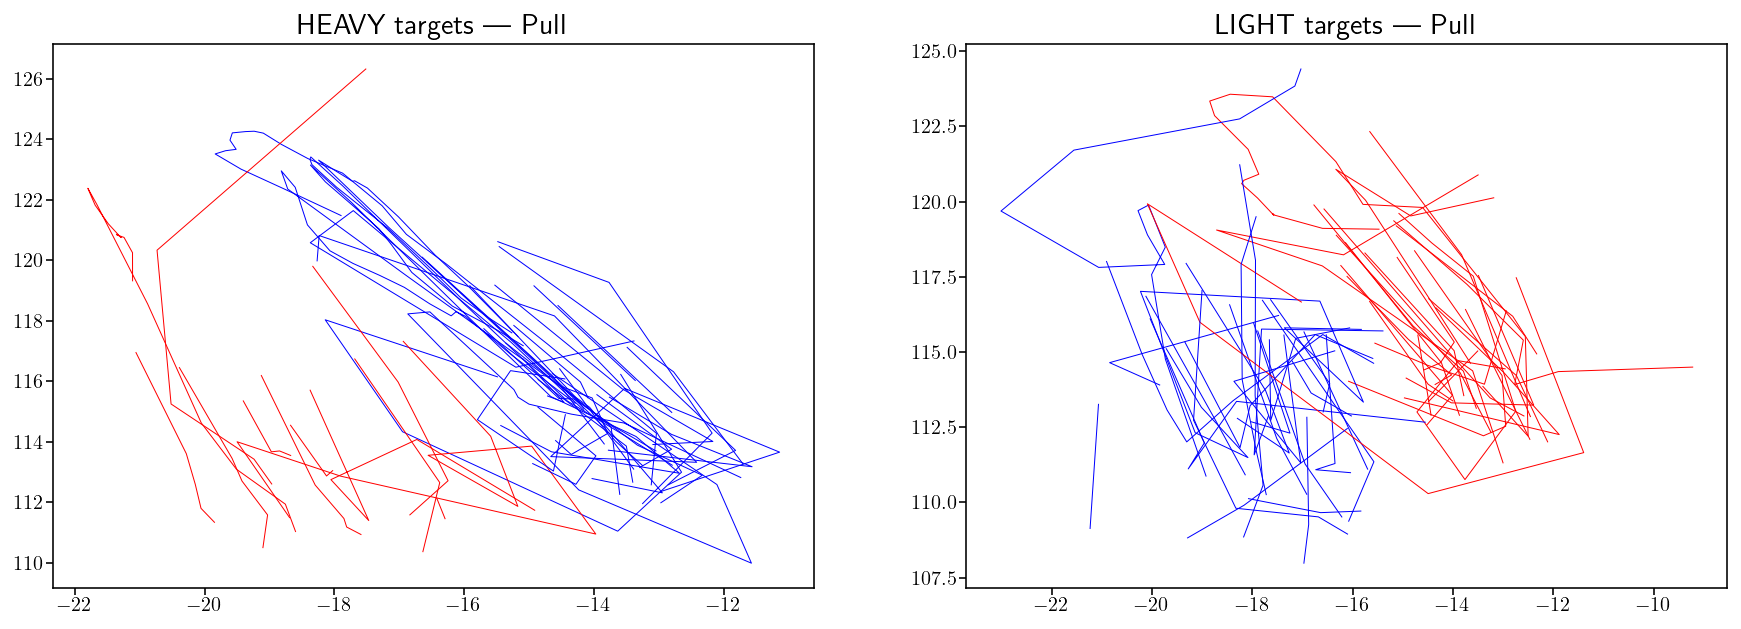

In [63]:
# %config InlineBackend.close_figures = True
fig,axes = plt.subplots(1,2,figsize=(15,5))

plot_pull_phase(axes,df)

# plot all the data

In [64]:
with PdfPages(pathlib.Path.cwd() / 'figures' / 'mouse-traj.pdf') as pdf:
    for df in AllDFs:
        fig,axes = plt.subplots(2,2,figsize=(15,10))
        
        plot_pull_phase(axes[1,:],df)
        plot_reach_phase(axes[0,:],df)
        fig.suptitle(f"Session: {df.file[0].replace('_','-')}")
        
        pdf.savefig()  # saves the current figure into a pdf page
        plt.close()

the pull phase is more consistent:

**check the duration of the pull phase**

In [65]:
def pull_phase_duration(df):
    light = []
    heavy = []
    for i,traj in enumerate(df.hTrjB):
        if df.target_id[i] in (0,2):
            key = heavy
        elif df.target_id[i] in (1,3):
            key = light
        else:
            continue
        getattr(key,'append')((np.sum(np.logical_not(np.isnan(traj[:,0])))-df.idx_pull_on[i])*df.bin_size[0])

    return light, heavy

    
with PdfPages(pathlib.Path.cwd() / 'figures' / 'mouse-pull-duration.pdf') as pdf:
    for df in AllDFs:
        fig,axes = plt.subplots(1,2,figsize=(10,5))
        
        light, heavy = pull_phase_duration(df)
        axes[0].hist(light)
        axes[0].set_title('light')
        axes[1].hist(heavy)
        axes[1].set_title('heavy')
        
        for ax in axes:
            ax.set_xlim([0,ax.get_xlim()[1]])
            ax.set_xlabel('Pull duration (s)')
            ax.set_ylabel(r'\# of trials')
        
        fig.suptitle(f"Session: {df.file[0].replace('_','-')}")
        
        pdf.savefig()  # saves the current figure into a pdf page
        plt.close()
print('Done')

Done


# Plot average firing rates

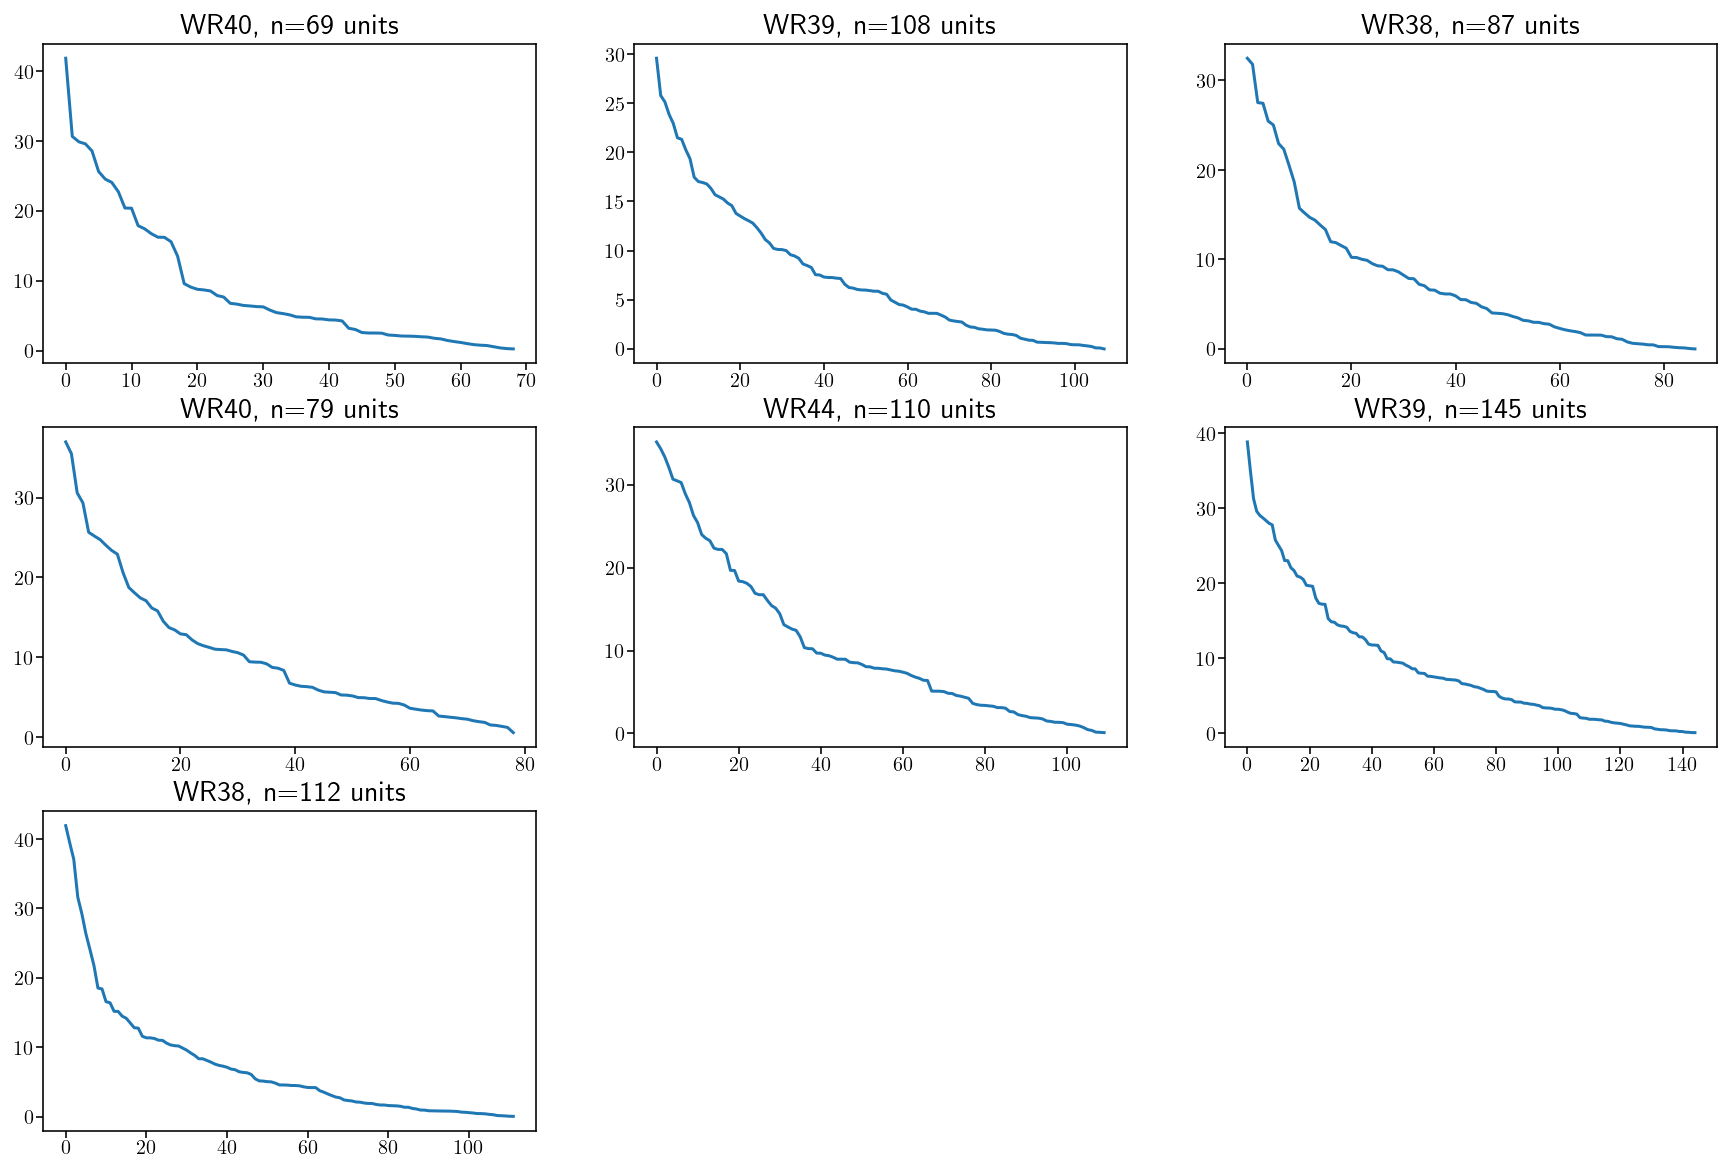

In [76]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(15,10))

signal = 'M1_rates'
signal = 'Str_rates'
for i,df in enumerate(AllDFs):
    ax = plt.subplot(3,3,i+1)    
    if signal not in df.columns: continue
    df_ = pyal.restrict_to_interval(df,epoch_fun=exec_epoch)
    a = pyal.get_average_firing_rates(df_,signal)
    a.sort()
    ax.plot(a[::-1])
    ax.set_title(f'{df_.mouse[0]}, n={a.shape[0]} units')

warnings.filterwarnings("default")

PCA explained variance

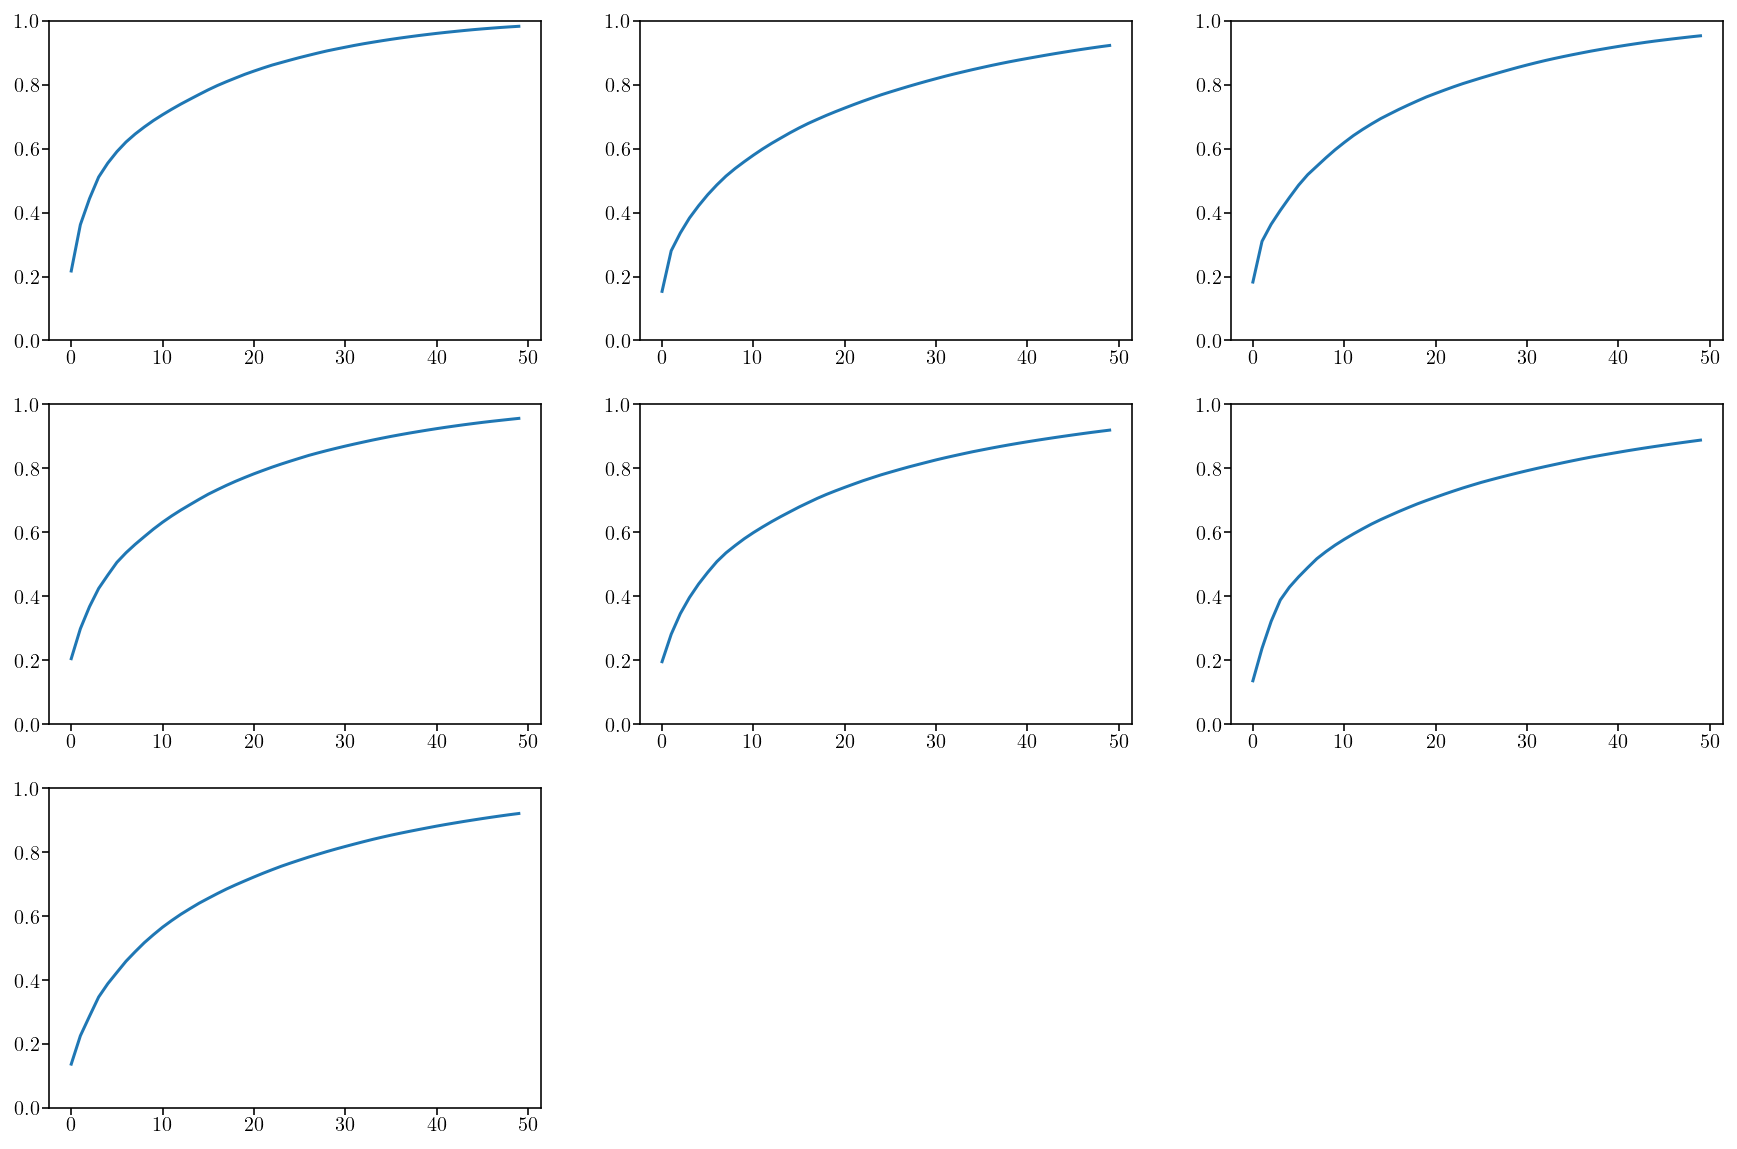

In [67]:
plt.figure(figsize=(15,10))
warnings.filterwarnings("ignore")

for i,df in enumerate(AllDFs):
    ax = plt.subplot(3,3,i+1)
    df_ = pyal.restrict_to_interval(df, epoch_fun=exec_epoch)
    rates = np.concatenate(df_['Str_rates'].values, axis=0)
    rates -= np.mean(rates, axis=0)
    rates_model = PCA(n_components=50, svd_solver='full').fit(rates)
    ax.plot(np.cumsum(rates_model.explained_variance_ratio_))
    ax.set_ylim([0,1])
warnings.filterwarnings("default")

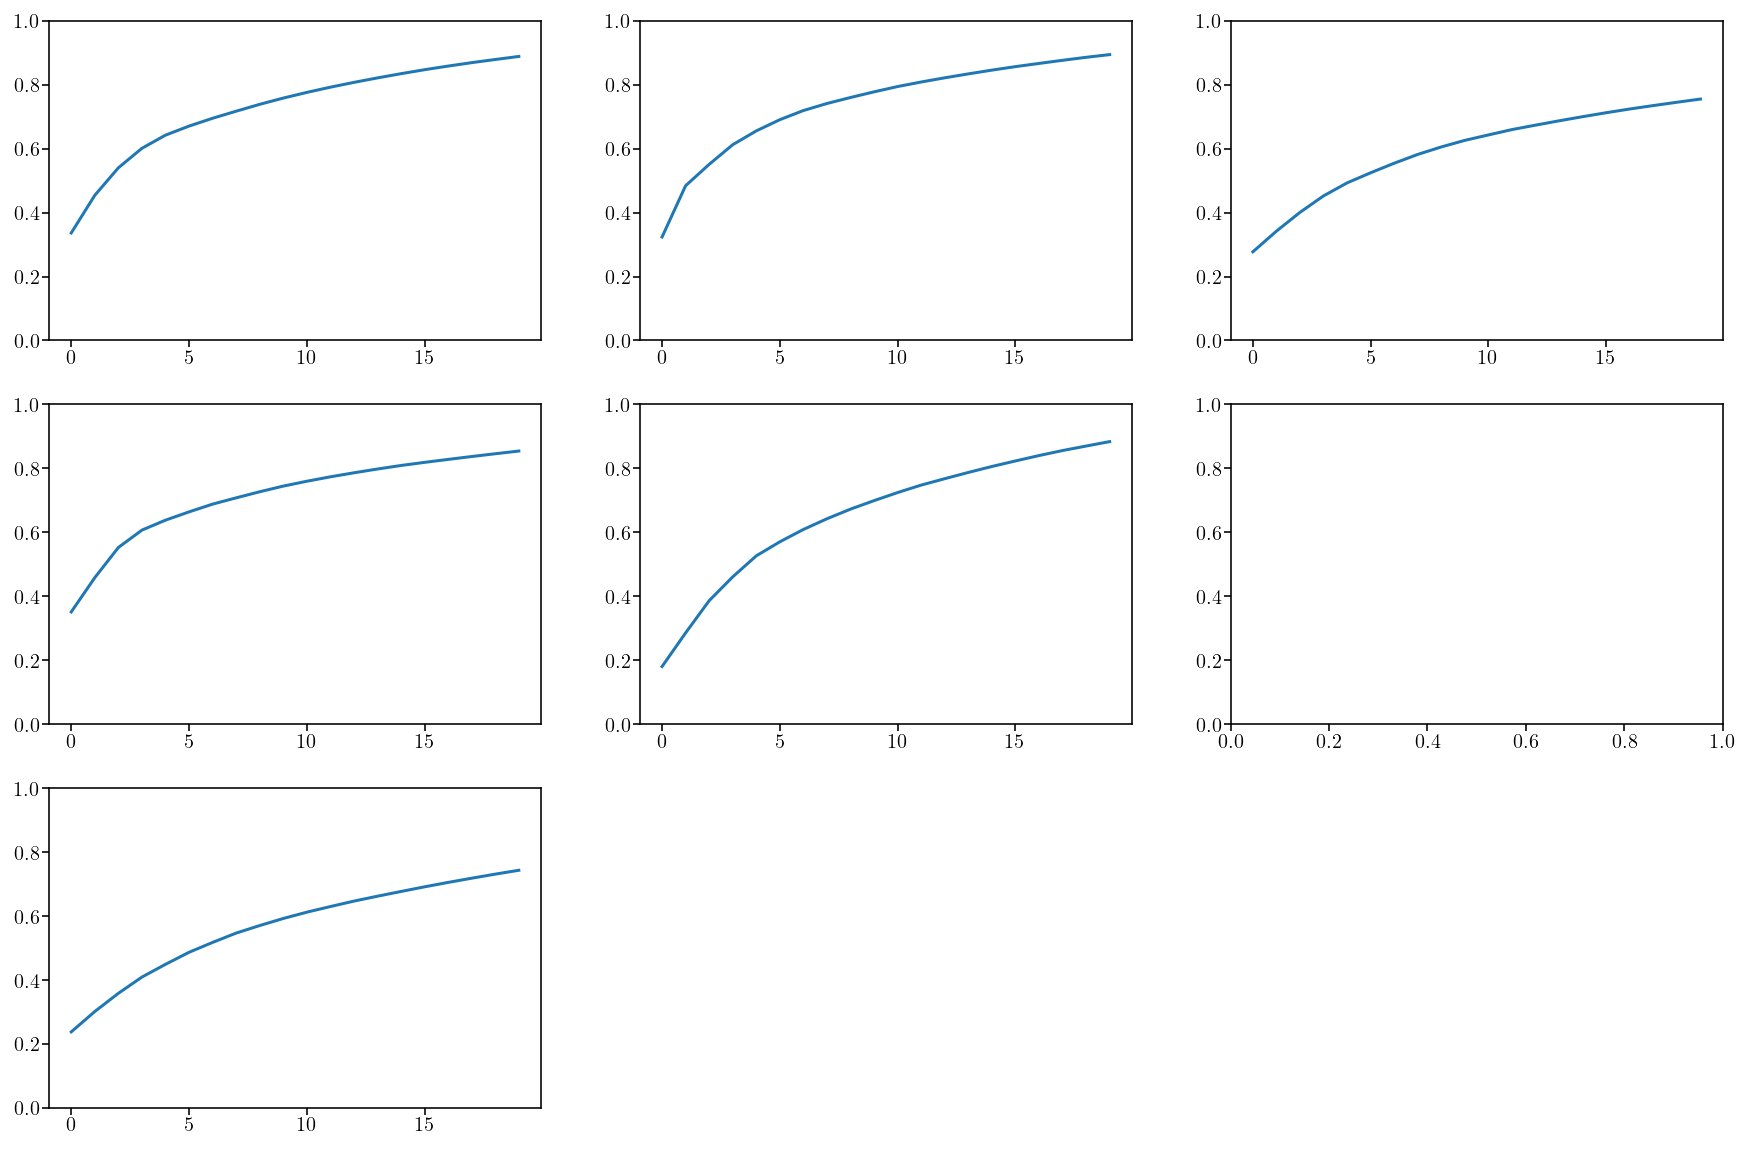

In [56]:
warnings.filterwarnings("ignore")

plt.figure(figsize=(15,10))
for i,df in enumerate(AllDFs):
    ax = plt.subplot(3,3,i+1)
    df_ = pyal.restrict_to_interval(df, epoch_fun=exec_epoch)
    try:
        rates = np.concatenate(df_['M1_rates'].values, axis=0)
    except KeyError:
        continue
    rates -= np.mean(rates, axis=0)
    rates_model = PCA(n_components=20, svd_solver='full').fit(rates)
    ax.plot(np.cumsum(rates_model.explained_variance_ratio_))
    ax.set_ylim([0,1])
    
warnings.filterwarnings("default")

Check the number of trials per target

In [57]:
for df in AllDFs:
    print({df.file[0]})
    for target in np.unique(df.target_id):
        df_ = pyal.select_trials(df, df.target_id == target)
        print(f'target[{target}]: {len(df_.Str_rates)}')
    print()

{'js2p0_tbytSpkHandJsTrj10msBin_WR40_081919_ss.mat'}
target[0]: 13
target[1]: 25
target[2]: 29
target[3]: 27

{'js2p0_tbytSpkHandJsTrj10msBin_WR39_100219_ss.mat'}
target[0]: 15
target[1]: 26
target[2]: 21
target[3]: 25

{'js2p0_tbytSpkHandJsTrj10msBin_WR38_052219_ss.mat'}
target[0]: 20
target[1]: 39
target[2]: 34
target[3]: 28

{'js2p0_tbytSpkHandJsTrj10msBin_WR40_082019_ss.mat'}
target[0]: 14
target[1]: 28
target[2]: 14
target[3]: 13

{'js2p0_tbytSpkHandJsTrj10msBin_WR44_031020_ss.mat'}
target[0]: 19
target[1]: 28
target[2]: 24
target[3]: 36

{'js2p0_tbytSpkHandJsTrj10msBin_WR39_100819_np2p0_strOnly_ss.mat'}
target[0]: 10
target[1]: 27
target[2]: 23
target[3]: 27

{'js2p0_tbytSpkHandJsTrj10msBin_WR38_052419_ss.mat'}
target[0]: 16
target[1]: 19
target[2]: 22
target[3]: 19

